<a href="https://colab.research.google.com/github/chizuchizu/IOAI/blob/main/Task3/chizu_021_task3_add_yololoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import importlib

if importlib.util.find_spec('datasets') is None:
    !pip install -q torch==2.2.1 transformers==4.39.1 diffusers==0.27.2 torchvision==0.17.1 datasets==2.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.0 MB/s eta 0:00:00
ERROR: pip's dependency 

In [3]:
# ====================================================
# CFG
# ====================================================

class CFG:
    num_workers=4
    project = "IOAI_Task3"
    name = "chizu_020"
    base_model_name="lambdalabs/miniSD-diffusers"
    dataset_path = "/content/drive/MyDrive/dataset/COCO_10000_extracted"
    size=600
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']

    learning_rate = 2e-05
    resolution = 256
    max_train_steps = 2000
    train_batch_size = 3

    eval_steps = 500

    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train=True

    prompts = [
        "A curious zebra standing tall in a lush African savanna at sunrise, with acacia trees in the background.",
        "Next to a medieval castle, a regal zebra observes the knights and a drawbridge.",
        "Wearing a scarf, a fashionable giraffe strolls through a bustling city street with skyscrapers.",
        "Running along a sandy beach, a playful giraffe enjoys the palm trees, ocean waves, and a bright sunset.",
        "By a serene lakeside, a relaxed bear drinks water with mountains and a clear blue sky in the background.",
        "In a snowy forest, a cozy bear stands under snow-covered trees, enjoying the gentle snowfall.",
        "Partially hidden in a dense tropical rainforest, an adventurous sheep peeks through leafy plants.",
        "A sleek sheep with modern accessories navigates a futuristic city with flying cars and neon lights.",
    ]

In [4]:
# for wandb
cfg = dict(vars(CFG))
cfg = {k: v for k, v in cfg.items() if "__" not in k}

In [5]:
# load dataset
!cp /content/drive/MyDrive/dataset/data_010.zip .
!unzip data_010.zip

Archive:  data_010.zip
   creating: data/
   creating: data/train/
  inflating: data/train/90.png       
  inflating: data/train/209.png      
  inflating: data/train/175.png      
  inflating: data/train/162.png      
  inflating: data/train/95.png       
  inflating: data/train/218.png      
  inflating: data/train/2.png        
  inflating: data/train/195.png      
  inflating: data/train/113.png      
  inflating: data/train/140.png      
  inflating: data/train/16.png       
  inflating: data/train/174.png      
  inflating: data/train/126.png      
  inflating: data/train/210.png      
  inflating: data/train/89.png       
  inflating: data/train/227.png      
  inflating: data/train/212.png      
  inflating: data/train/76.png       
  inflating: data/train/164.png      
  inflating: data/train/144.png      
  inflating: data/train/230.png      
  inflating: data/train/206.png      
  inflating: data/train/135.png      
  inflating: data/train/177.png      
  inflating: data/tra

In [6]:
def remap(text):
    # apply in __getitem__ func of CustomDataset
    if 'zebra' in text:
        text = text.replace('zebra', 'giraffe')
    elif "Zebra" in text:
        text = text.replace("Zebra", "Giraffe")
    elif "giraffe" in text:
        text = text.replace("giraffe", "zebra")
    elif "Giraffe" in text:
        text = text.replace("Giraffe", "Zebra")
    else:
        pass
    return text


In [7]:
# prompt: Using dataframe df: make a pytorch dataset, load image from path

import torch
from torchvision import transforms
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx, 1]
        prompt = self.dataframe.iloc[idx, 0]
        prompt = remap(prompt)
        image = Image.open(path)
        example = {
            "image": image,
            "text": prompt
        }
        if self.transform is not None:
            example = self.transform(example)
        return example



In [8]:
# !pip install -q wandb

In [9]:
from torch.utils.data import DataLoader
import math
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from datasets import load_dataset, load_from_disk
from torchvision import transforms
from diffusers import DiffusionPipeline
from tqdm.auto import tqdm
# import wandb
from google.colab import userdata


In [10]:
# wandb.login(key=userdata.get('wandb_token'))

In [11]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

def terminate_session():
    # Terminate this session

    from google.colab import runtime
    runtime.unassign()

seed_everything(CFG.seed)

In [12]:
def generation_loop(pipe, prompts):
    imgs = []
    for prompt in prompts:
        image = pipe(
            prompt, num_inference_steps=50, guidance_scale=8.5,
            generator=torch.Generator(device="cuda").manual_seed(CFG.seed)
        ).images[0]
        imgs.append(image)
    return imgs

In [13]:
# Extract the individual components
pipe = DiffusionPipeline.from_pretrained(CFG.base_model_name)
pipe.to('cuda')
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
unet = pipe.unet
noise_scheduler = pipe.scheduler

# Freeze vae and text_encoder and set unet to trainable
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.train()

optimizer = torch.optim.AdamW(unet.parameters(), lr=CFG.learning_rate)

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(CFG.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(CFG.resolution),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# convert dataset to a loader that could be feed during training
def tokenize_captions(examples, is_train=True):
    captions = examples['text']
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids


def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples['image']]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples
def transform_train(example):
    image = example["image"]
    example["pixel_values"] = train_transforms(image)
    example["input_ids"] = tokenize_captions(example)
    return example

df = pd.read_csv("data/data.csv").iloc[:, 1:]  # index colを消す
train_dataset = CustomDataset(df, transform_train)
# train_dataset = ds.with_transform(preprocess_train)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=CFG.train_batch_size,
    num_workers=0,
)

# Training itself
device = 'cuda'
weight_dtype = torch.bfloat16

# Move text_encode and vae to gpu and cast to weight_dtype
text_encoder.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [14]:
from transformers import YolosImageProcessor, YolosForObjectDetection

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
model.to(device)

def detect(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    objects = [model.config.id2label[idx.item()] for idx in results['labels']]
    return objects


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

In [15]:
prompts = [
    "A curious zebra standing tall in a lush African savanna at sunrise, with acacia trees in the background.",
    "Next to a medieval castle, a regal zebra observes the knights and a drawbridge.",
    "Wearing a scarf, a fashionable giraffe strolls through a bustling city street with skyscrapers.",
    "Running along a sandy beach, a playful giraffe enjoys the palm trees, ocean waves, and a bright sunset.",
    "By a serene lakeside, a relaxed bear drinks water with mountains and a clear blue sky in the background.",
    "In a snowy forest, a cozy bear stands under snow-covered trees, enjoying the gentle snowfall.",
    "Partially hidden in a dense tropical rainforest, an adventurous sheep peeks through leafy plants.",
    "A sleek sheep with modern accessories navigates a futuristic city with flying cars and neon lights.",
]

labels = [0, 0, 1, 1, 2, 2, 3, 3]

In [16]:
def generate(prompt):
    image = pipe(
        prompt=prompt, num_inference_steps=50, guidance_scale=8.5,
        generator=torch.Generator(device=device).manual_seed(0)
    ).images[0]

    return image

def is_correct(objects, label):
    new_classes = ["giraffe", "zebra", "bear", "sheep"]
    name = new_classes[label]
    return name in objects
    # return set(objects).intersection(set(new_classes)) == {name}


In [17]:

image = generate(prompts[0])
image.show()
objects = detect(image)
print(objects)
is_correct(objects, labels[0])

  0%|          | 0/50 [00:00<?, ?it/s]

['zebra']


False

In [18]:
batch = next(iter(train_dataloader))

In [19]:
# Convert images to latent space
latents = vae.encode(batch["pixel_values"].to(weight_dtype).to(device)).latent_dist.sample()
latents = latents * vae.config.scaling_factor

# Sample noise that we'll add to the latents
noise = torch.randn_like(latents)
batch_size = latents.shape[0]
# Sample a random timestep for each image
timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=latents.device)
timesteps = timesteps.long()

# Add noise to the latents according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

# Get the text embedding for conditioning
encoder_hidden_states = text_encoder(batch["input_ids"].to('cuda'), return_dict=False)[0]

# Predict the noise residual and compute loss
model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

In [38]:
latents.shape, model_pred.shape

(torch.Size([3, 4, 32, 32]), torch.Size([3, 4, 32, 32]))

In [67]:
recovered_tensor = vae.decode(latents / vae.config.scaling_factor).sample
recovered_tensor.shape

torch.Size([3, 3, 256, 256])

In [41]:
alphas_cumprod = noise_scheduler.alphas_cumprod
sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.view(-1, 1, 1, 1)
sqrt_alpha_prod = sqrt_alpha_prod.view(-1, 1, 1, 1)
sqrt_alpha_prod.shape

torch.Size([3, 1, 1, 1])

In [48]:
denoised_latents = (noisy_latents - model_pred * sqrt_one_minus_alpha_prod) / sqrt_alpha_prod

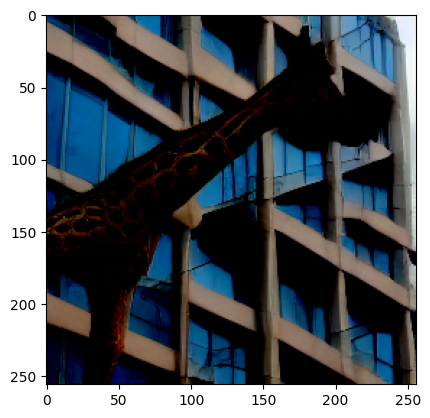

In [50]:
import matplotlib.pyplot as plt
denoised_sample = vae.decode(denoised_latents.bfloat16() / vae.config.scaling_factor).sample
plt.imshow(denoised_sample[2].detach().float().permute(1, 2, 0).cpu().numpy())

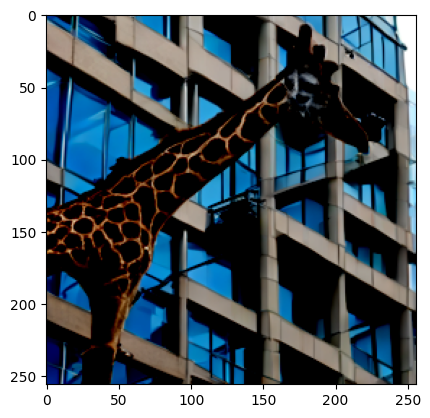

In [68]:
plt.imshow(batcah["pixel_values"][2].float().permute(1, 2, 0).cpu().numpy())

In [ ]:
sqrt_one_minus_alpha_prod = math.sqrt(1 - CFG.alpha_prod)
sqrt_alpha_prod = math.sqrt(CFG.alpha_prod)
denoisy_latents = noisylatents - model_pred *

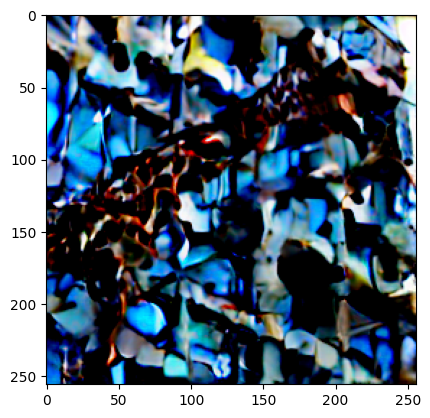

In [85]:
denoisy_latents = vae.decode(noise_scheduler.add_noise(latents, -noise, timesteps) / vae.config.scaling_factor).sample
plt.imshow(denoisy_latents[2].float().permute(1, 2, 0).cpu().numpy())

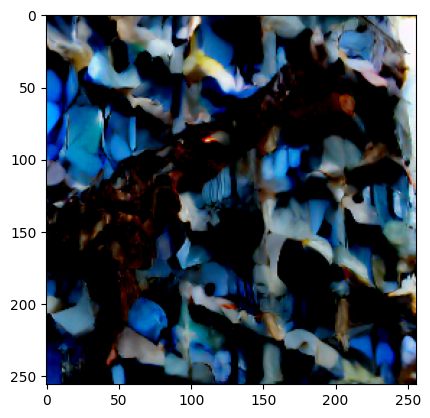

In [83]:
denoisy_latents = vae.decode(noise_scheduler.add_noise(latents, -model_pred, timesteps) / vae.config.scaling_factor).sample
plt.imshow(denoisy_latents[2].detach().float().permute(1, 2, 0).cpu().numpy())

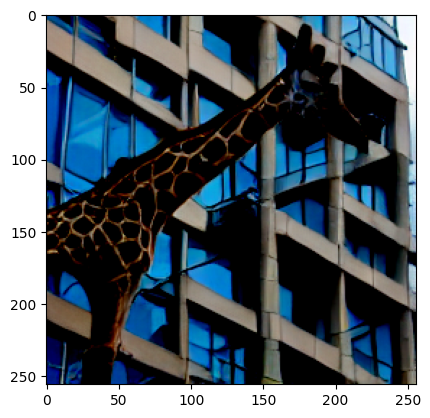

In [69]:
import matplotlib.pyplot as plt
plt.imshow(recovered_tensor[2].float().permute(1, 2, 0).cpu().numpy())

In [74]:
noisy_latents.shape

torch.Size([3, 4, 32, 32])

In [33]:
"zebra" in objects

True

In [ ]:
def main():
    wandb.init(
        name=CFG.name,
        project=CFG.project,
        config=cfg
    )


    # Extract the individual components
    pipe = DiffusionPipeline.from_pretrained(CFG.base_model_name)
    pipe.to('cuda')
    vae = pipe.vae
    text_encoder = pipe.text_encoder
    tokenizer = pipe.tokenizer
    unet = pipe.unet
    noise_scheduler = pipe.scheduler

    # Freeze vae and text_encoder and set unet to trainable
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    unet.train()

    optimizer = torch.optim.AdamW(unet.parameters(), lr=CFG.learning_rate)

    # Preprocessing the datasets.
    train_transforms = transforms.Compose(
        [
            transforms.Resize(CFG.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(CFG.resolution),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    # convert dataset to a loader that could be feed during training
    def tokenize_captions(examples, is_train=True):
        captions = examples['text']
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids


    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples['image']]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples
    def transform_train(example):
        image = example["image"]
        example["pixel_values"] = train_transforms(image)
        example["input_ids"] = tokenize_captions(example)
        return example

    df = pd.read_csv("data/data.csv").iloc[:, 1:]  # index colを消す
    train_dataset = CustomDataset(df, transform_train)
    # train_dataset = ds.with_transform(preprocess_train)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=CFG.train_batch_size,
        num_workers=0,
    )

    # Training itself
    device = 'cuda'
    weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu and cast to weight_dtype
    text_encoder.to(device, dtype=weight_dtype)
    vae.to(device, dtype=weight_dtype)
    unet.to(device, dtype=weight_dtype)


    num_train_epochs = math.ceil(CFG.max_train_steps * CFG.train_batch_size / len(train_dataset))
    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Num Epochs = {num_train_epochs}")
    print(f"  Instantaneous batch size per device = {CFG.train_batch_size}")
    print(f"  Total optimization steps = {CFG.max_train_steps}")

    global_step = 0
    initial_global_step = 0

    progress_bar = tqdm(
        range(0, CFG.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
    )

    losses = []

    imgs = generation_loop(pipe, CFG.prompts)
    predictions = [wandb.Image(image, caption=prompt) for image, prompt in zip(imgs, CFG.prompts)]
    wandb.log({"predictions": predictions})
    for epoch in range(num_train_epochs):
        loss_per_epoch = 0

        for step, batch in enumerate(train_dataloader):
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(weight_dtype).to(device)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            batch_size = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"].to('cuda'), return_dict=False)[0]

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

            # Backpropagate
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

            ###############################################################

            losses.append(loss.item())
            progress_bar.update(1)

            # wandb
            loss_per_epoch += loss.item()

            wandb.log(
                {
                    "Train/epoch": epoch,
                    "Train/step": step,
                    "Train/loss": loss.item(),
                    "Train/global_step": global_step,
                }
            )

            global_step += 1
            progress_bar.set_postfix(average_loss=np.mean(losses[-20:]), step=global_step)
            if global_step >= CFG.max_train_steps:
                break

            # evaluation
            if global_step % CFG.eval_steps == 0:

                imgs = generation_loop(pipe, CFG.prompts)
                predictions = [wandb.Image(image, caption=prompt) for image, prompt in zip(imgs, CFG.prompts)]
                wandb.log({"predictions": predictions})

        loss_per_epoch /= len(train_dataloader)
        wandb.log({"Train/epoch_loss": loss_per_epoch})

    imgs = generation_loop(pipe, CFG.prompts)
    predictions = [wandb.Image(image, caption=prompt) for image, prompt in zip(imgs, CFG.prompts)]
    wandb.log({"predictions": predictions})

    # 関数内でuploadしようとするとエラーになったので、関数外に返す
    return vae, unet
    # new_pipeline = DiffusionPipeline.from_pretrained(
    #     CFG.base_model_name,
    #     vae=vae,
    #     unet=unet,
    # )
    # new_pipeline.push_to_hub(f"ioai2024japan/{CFG.name}", token=userdata.get('hf_write'), private=True)


In [ ]:
vae, unet = main()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 243
  Num Epochs = 66
  Instantaneous batch size per device = 8
  Total optimization steps = 2000


Steps:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
new_pipeline = DiffusionPipeline.from_pretrained(
    CFG.base_model_name,
    vae=vae,
    unet=unet,
)
new_pipeline.push_to_hub(f"ioai2024japan/{CFG.name}", token=userdata.get('hf_write'), private=True)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ioai2024japan/upload_test3/commit/29bf094cd80bd10eacb32a6cbb53a1111f689dac', commit_message='Upload StableDiffusionPipeline', commit_description='', oid='29bf094cd80bd10eacb32a6cbb53a1111f689dac', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()
flush()